In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
import datetime

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, processor, data_dir):
        self.dataframe = dataframe
        self.processor = processor
        self.data_dir = data_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.data_dir, row['image_path'])
        image = Image.open(image_path).convert('RGB')
        text = row['text']

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding='max_length', truncation=True)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'pixel_values': inputs['pixel_values'].squeeze()
        }

In [ ]:
class CLIPTrainer:
    def __init__(self, model_name, data_dir, metadata_path, use_validation=True):
        self.data_dir = data_dir
        self.metadata_path = metadata_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)

        self.use_validation = use_validation

        self.df = pd.read_csv(metadata_path)
        if self.use_validation:
            self.train_df, self.val_df = train_test_split(self.df, test_size=0.1, random_state=42)
            self.train_dataset = CustomDataset(self.train_df, self.processor, self.data_dir)
            self.val_dataset = CustomDataset(self.val_df, self.processor, self.data_dir)
        else:
            self.train_dataset = CustomDataset(self.df, self.processor, self.data_dir)

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        if self.use_validation:
            self.val_dataloader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)

        self.train_losses = []
        self.val_losses = []
        self.checkpoint_dir = self.create_checkpoint_dir()

    def create_checkpoint_dir(self):
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_dir = os.path.join("model_checkpoints", f"run_{timestamp}")
        os.makedirs(checkpoint_dir, exist_ok=True)
        return checkpoint_dir

    def save_model(self, filename):
        path = os.path.join(self.checkpoint_dir, filename)
        self.model.save_pretrained(path)
        self.processor.save_pretrained(path)
        print(f"Model saved to {path}")

    def visualize_samples(self, dataset, num_samples=5):
        sampled_indices = random.sample(range(len(dataset)), num_samples)

        fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5*num_samples))
        fig.tight_layout(pad=5.0)

        for i, idx in enumerate(sampled_indices):
            sample = dataset[idx]
            image = sample['pixel_values'].cpu().permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())

            axs[i].imshow(image)
            axs[i].set_title(f"Image {i+1}")
            axs[i].axis('off')

            caption = self.df.iloc[idx]['text']
            axs[i].set_xlabel(f"Caption: {caption}", wrap=True)

            print(f"Image {i+1} - Raw Min: {sample['pixel_values'].min():.4f}, Raw Max: {sample['pixel_values'].max():.4f}")
            print(f"Image {i+1} - Min After Normalization: {image.min():.4f}, Max After Normalization: {image.max():.4f}")

        plt.show()

        for i, idx in enumerate(sampled_indices):
            print(f"Image {i+1} Caption: {self.df.iloc[idx]['text']}")

    @staticmethod
    def contrastive_loss(logits):
        labels = torch.arange(len(logits), device=logits.device)
        return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2

    def train(self, num_epochs, learning_rate=5e-5, save_interval=5, use_scheduler=True):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)

        print("Training started...")
        print(f"Number of epochs: {num_epochs}")
        print(f"Learning rate: {learning_rate}")
        print(f"Use scheduler: {use_scheduler}")
        print(f"Save interval: {save_interval}")
        print(f"Use validation: {self.use_validation}")
        print(f"Device: {self.device}")
        print(f"Model name: {self.model.config.name_or_path}")
        print(f"Model type: {type(self.model).__name__}")

        if self.use_validation:
            print(f"Training dataset size: {len(self.train_dataset)}")
            print(f"Validation dataset size: {len(self.val_dataset)}")
            print(f"Batch size: {self.train_dataloader.batch_size}")
            print(f"Number of batches in training: {len(self.train_dataloader)}")
            print(f"Number of batches in validation: {len(self.val_dataloader)}")
            print(f"Number of training steps: {len(self.train_dataloader) * num_epochs}")

        else:
            print(f"Training dataset size: {len(self.train_dataset)}")
            print(f"Batch size: {self.train_dataloader.batch_size}")
            print(f"Number of batches in training: {len(self.train_dataloader)}")
            print(f"Number of training steps: {len(self.train_dataloader) * num_epochs}")

        print("-" * 50)

        if use_scheduler:
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(self.train_dataloader) * num_epochs)
        else:
            scheduler = None

        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            progress_bar = tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for batch in progress_bar:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                pixel_values = batch['pixel_values'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
                loss = self.contrastive_loss(outputs.logits_per_image)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if scheduler:
                    scheduler.step()
                total_loss += loss.item()

                progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})

            avg_train_loss = total_loss / len(self.train_dataloader)
            self.train_losses.append(avg_train_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

            if self.use_validation:
                val_loss = self.validate()
                self.val_losses.append(val_loss)
                print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.save_model('best_model')
                    print(f"New best model saved with validation loss: {best_val_loss:.4f}")

            if (epoch + 1) % save_interval == 0:
                self.save_model(f'model_epoch_{epoch+1}')
                print(f"Model saved at epoch {epoch+1}")

        self.save_model('final_model')
        print("Training completed. Final model saved.")
        self.plot_training_progress()

    def plot_training_progress(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        if self.use_validation:
            plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.savefig(os.path.join(self.checkpoint_dir, 'training_progress.png'))
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.savefig(os.path.join(self.checkpoint_dir, 'training_loss.png'))
        plt.close()

        if self.use_validation:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Validation Loss Over Time')
            plt.legend()
            plt.savefig(os.path.join(self.checkpoint_dir, 'validation_loss.png'))
            plt.close()

    def validate(self):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in self.val_dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                pixel_values = batch['pixel_values'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
                loss = self.contrastive_loss(outputs.logits_per_image)
                val_loss += loss.item()

        return val_loss / len(self.val_dataloader)

    def run_inference(self, model, image_path, text_options, actual_prompt):
        image = Image.open(image_path).convert('RGB')
        inputs = self.processor(images=image, text=text_options, return_tensors="pt", padding=True).to(self.device)

        with torch.no_grad():
            outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        predicted_index = torch.argmax(probs).item()
        predicted_label = text_options[predicted_index]
        actual_index = text_options.index(actual_prompt)

        print(f"Actual Prompt: {actual_prompt}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Confidence: {probs[0, predicted_index].item() * 100:.2f}%")
        print(f"True Label Confidence: {probs[0, actual_index].item() * 100:.2f}%")

        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}\nConfidence: {probs[0, predicted_index].item() * 100:.2f}%")
        plt.axis('off')
        plt.show()

    def run_inference_on_validation(self, inference_save_dir, image_paths, prompts):
        model_dir = os.path.join(self.checkpoint_dir, inference_save_dir)
        model = CLIPModel.from_pretrained(model_dir).to(self.device)
        processor = CLIPProcessor.from_pretrained(model_dir)

        for i, (image_path, actual_prompt) in enumerate(zip(image_paths, prompts)):
            self.run_inference(model, image_path, prompts, actual_prompt)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/CLIP_training_data"
metadata_path = os.path.join(data_dir, "metadata.csv")

trainer = "openai/clip-vit-base-patch32"


# model_id = "CompVis/stable-diffusion-v1-4"
# tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
# text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

Mounted at /content/drive


In [ ]:
# # Usage for Experiment 1
# trainer_exp1 = CLIPTrainer(trainer, data_dir, metadata_path, use_validation=False)
# trainer_exp1.train(num_epochs=3, learning_rate=5e-5, use_scheduler=True)



In [ ]:
# # Experiment 2
# trainer_exp2 = CLIPTrainer(trainer, data_dir, metadata_path, use_validation=True)

# trainer_exp2.visualize_samples(trainer_exp2.train_dataset, num_samples=5)

In [ ]:
# trainer_exp2.train(num_epochs=3, learning_rate=5e-5, use_scheduler=True)

# trainer_exp2.run_inference_on_validation('final_model',

Experiment 3


In [ ]:
class CLIPTrainer:
    def __init__(self, model_name, data_dir, metadata_path,
                 batch_size=32, learning_rate=5e-5, num_epochs=3,
                 use_scheduler=True, save_interval=5):
        self.data_dir = data_dir
        self.metadata_path = metadata_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.use_scheduler = use_scheduler
        self.save_interval = save_interval

        self.df = pd.read_csv(metadata_path)
        self.train_df, temp_df = train_test_split(self.df, test_size=0.1, random_state=42)
        self.val_df, self.test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

        self.train_dataset = CustomDataset(self.train_df, self.processor, self.data_dir)
        self.val_dataset = CustomDataset(self.val_df, self.processor, self.data_dir)
        self.test_dataset = CustomDataset(self.test_df, self.processor, self.data_dir)

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

        self.train_losses = []
        self.val_losses = []
        self.checkpoint_dir = self.create_checkpoint_dir()

    def create_checkpoint_dir(self):
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_dir = os.path.join("model_checkpoints", f"run_{timestamp}")
        os.makedirs(checkpoint_dir, exist_ok=True)
        return checkpoint_dir

    def save_model(self, filename):
        path = os.path.join(self.checkpoint_dir, filename)
        self.model.save_pretrained(path)
        self.processor.save_pretrained(path)
        print(f"Model saved to {path}")

    def visualize_samples(self, dataset, num_samples=5):
        sampled_indices = random.sample(range(len(dataset)), num_samples)

        fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5*num_samples))
        fig.tight_layout(pad=5.0)

        for i, idx in enumerate(sampled_indices):
            sample = dataset[idx]
            image = sample['pixel_values'].cpu().permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())

            axs[i].imshow(image)
            axs[i].set_title(f"Image {i+1}")
            axs[i].axis('off')

            caption = self.df.iloc[idx]['text']
            axs[i].set_xlabel(f"Caption: {caption}", wrap=True)

            print(f"Image {i+1} - Raw Min: {sample['pixel_values'].min():.4f}, Raw Max: {sample['pixel_values'].max():.4f}")
            print(f"Image {i+1} - Min After Normalization: {image.min():.4f}, Max After Normalization: {image.max():.4f}")

        plt.show()

        for i, idx in enumerate(sampled_indices):
            print(f"Image {i+1} Caption: {self.df.iloc[idx]['text']}")

    @staticmethod
    def contrastive_loss(logits):
        labels = torch.arange(len(logits), device=logits.device)
        return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2

    def train(self):
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

      print("Training started...")
      print(f"Number of epochs: {self.num_epochs}")
      print(f"Learning rate: {self.learning_rate}")
      print(f"Use scheduler: {self.use_scheduler}")
      print(f"Save interval: {self.save_interval}")
      print(f"Device: {self.device}")
      print(f"Model name: {self.model.config.name_or_path}")
      print(f"Model type: {type(self.model).__name__}")

      print(f"Training dataset size: {len(self.train_dataset)}")
      print(f"Validation dataset size: {len(self.val_dataset)}")
      print(f"Test dataset size: {len(self.test_dataset)}")
      print(f"Batch size: {self.train_dataloader.batch_size}")
      print(f"Number of batches in training: {len(self.train_dataloader)}")
      print(f"Number of batches in validation: {len(self.val_dataloader)}")
      print(f"Number of training steps: {len(self.train_dataloader) * self.num_epochs}")

      print("-" * 50)

      if self.use_scheduler:
          scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100,
                                                num_training_steps=len(self.train_dataloader) * self.num_epochs)
      else:
          scheduler = None

      best_val_loss = float('inf')

      for epoch in range(self.num_epochs):
          self.model.train()
          total_loss = 0
          progress_bar = tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.num_epochs}")

          for batch in progress_bar:
              input_ids = batch['input_ids'].to(self.device)
              attention_mask = batch['attention_mask'].to(self.device)
              pixel_values = batch['pixel_values'].to(self.device)

              outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
              loss = self.contrastive_loss(outputs.logits_per_image)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              if scheduler:
                  scheduler.step()
              total_loss += loss.item()

              progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})

          avg_train_loss = total_loss / len(self.train_dataloader)
          self.train_losses.append(avg_train_loss)
          print(f"Epoch {epoch+1}/{self.num_epochs}, Training Loss: {avg_train_loss:.4f}")

          val_loss = self.validate()
          self.val_losses.append(val_loss)
          print(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {val_loss:.4f}")

          if val_loss < best_val_loss:
              best_val_loss = val_loss
              self.save_model('best_model')
              print(f"New best model saved with validation loss: {best_val_loss:.4f}")

          if (epoch + 1) % self.save_interval == 0:
              self.save_model(f'model_epoch_{epoch+1}')
              print(f"Model saved at epoch {epoch+1}")

      self.save_model('final_model')
      print("Training completed. Final model saved.")
      self.plot_training_progress()

    def plot_training_progress(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.savefig(os.path.join(self.checkpoint_dir, 'training_progress.png'))
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.savefig(os.path.join(self.checkpoint_dir, 'training_loss.png'))
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Validation Loss Over Time')
        plt.legend()
        plt.savefig(os.path.join(self.checkpoint_dir, 'validation_loss.png'))
        plt.close()

    def validate(self):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in self.val_dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                pixel_values = batch['pixel_values'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
                loss = self.contrastive_loss(outputs.logits_per_image)
                val_loss += loss.item()

        return val_loss / len(self.val_dataloader)

    def run_inference_on_test_set(self, model_name, num_samples=5):
        model_dir = os.path.join(self.checkpoint_dir, model_name)
        model = CLIPModel.from_pretrained(model_dir).to(self.device)
        processor = CLIPProcessor.from_pretrained(model_dir)

        # Randomly sample from the test set
        sampled_test_df = self.test_df.sample(n=min(num_samples, len(self.test_df)))

        for _, row in sampled_test_df.iterrows():
            image_path = os.path.join(self.data_dir, row['image_path'])
            actual_prompt = row['text']

            # Get all unique prompts from the test set
            all_prompts = self.test_df['text'].unique().tolist()

            self.run_inference(model, processor, image_path, all_prompts, actual_prompt)

    def run_inference(self, model, processor, image_path, text_options, actual_prompt):
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, text=text_options, return_tensors="pt", padding=True).to(self.device)

        with torch.no_grad():
            outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        predicted_index = torch.argmax(probs).item()
        predicted_label = text_options[predicted_index]
        actual_index = text_options.index(actual_prompt)

        print(f"Image: {image_path}")
        print(f"Actual Prompt: {actual_prompt}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Confidence: {probs[0, predicted_index].item() * 100:.2f}%")
        print(f"True Label Confidence: {probs[0, actual_index].item() * 100:.2f}%")
        print("-" * 50)

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}\nActual: {actual_prompt}\nConfidence: {probs[0, predicted_index].item() * 100:.2f}%")
        plt.axis('off')
        plt.show()

Training started...
Number of epochs: 3
Learning rate: 5e-05
Use scheduler: True
Save interval: 1
Device: cuda
Model name: openai/clip-vit-base-patch32
Model type: CLIPModel
Training dataset size: 393
Validation dataset size: 22
Test dataset size: 22
Batch size: 32
Number of batches in training: 13
Number of batches in validation: 1
Number of training steps: 39
--------------------------------------------------


Epoch 1/3: 100%|██████████| 13/13 [00:37<00:00,  2.90s/it, training_loss=1.458]


Epoch 1/3, Training Loss: 2.4726
Epoch 1/3, Validation Loss: 1.9110
Model saved to model_checkpoints/run_20240810_214717/best_model
New best model saved with validation loss: 1.9110
Model saved to model_checkpoints/run_20240810_214717/model_epoch_1
Model saved at epoch 1


Epoch 2/3: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it, training_loss=0.606]


Epoch 2/3, Training Loss: 1.6285
Epoch 2/3, Validation Loss: 1.6400
Model saved to model_checkpoints/run_20240810_214717/best_model
New best model saved with validation loss: 1.6400
Model saved to model_checkpoints/run_20240810_214717/model_epoch_2
Model saved at epoch 2


Epoch 3/3: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, training_loss=0.389]


Epoch 3/3, Training Loss: 1.2246
Epoch 3/3, Validation Loss: 2.1464
Model saved to model_checkpoints/run_20240810_214717/model_epoch_3
Model saved at epoch 3
Model saved to model_checkpoints/run_20240810_214717/final_model
Training completed. Final model saved.
Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/-4784154530386898261.png
Actual Prompt: a at distance photo of eczema skin condition on arms on brown skin
Predicted Label: a at distance photo of eczema skin condition on arms on brown skin
Prediction Confidence: 28.42%
True Label Confidence: 28.42%
--------------------------------------------------


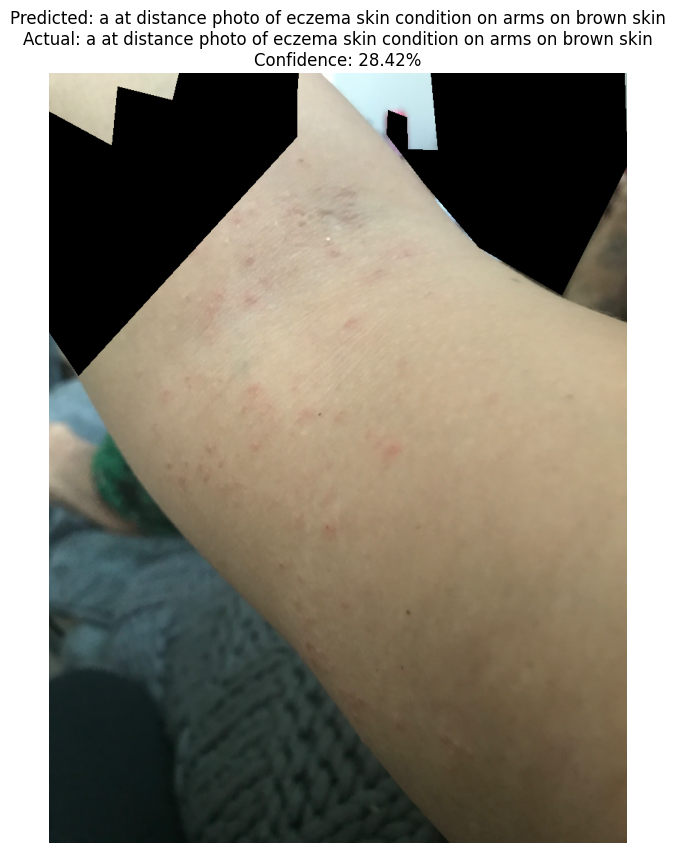

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/8943452377015009675.png
Actual Prompt: a close up photo of urticaria skin condition on arms on brown skin
Predicted Label: a close up photo of urticaria skin condition on torso on fair skin
Prediction Confidence: 55.09%
True Label Confidence: 0.76%
--------------------------------------------------


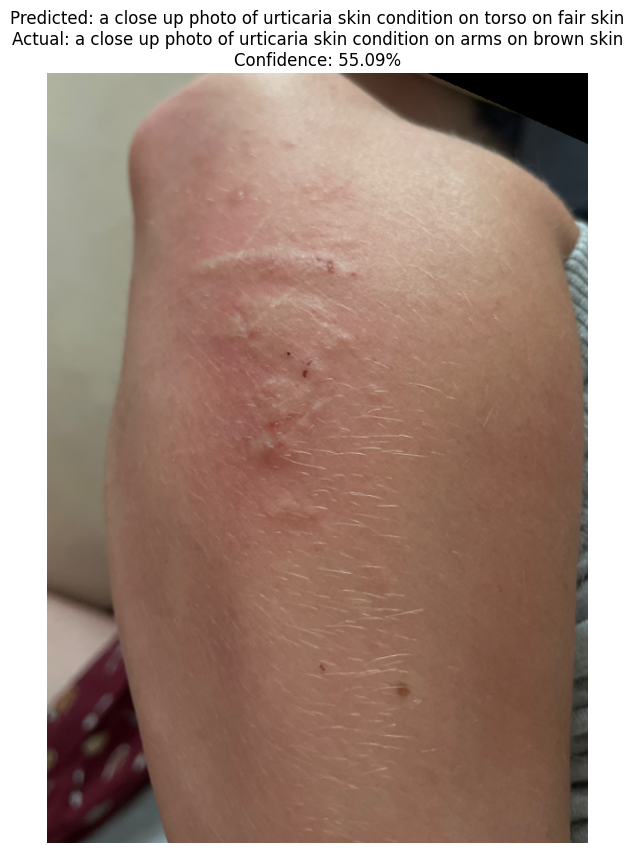

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/6698561070990105178.png
Actual Prompt: a close up photo of folliculitis skin condition on brown skin
Predicted Label: a close up photo of urticaria skin condition on torso on fair skin
Prediction Confidence: 47.37%
True Label Confidence: 44.38%
--------------------------------------------------


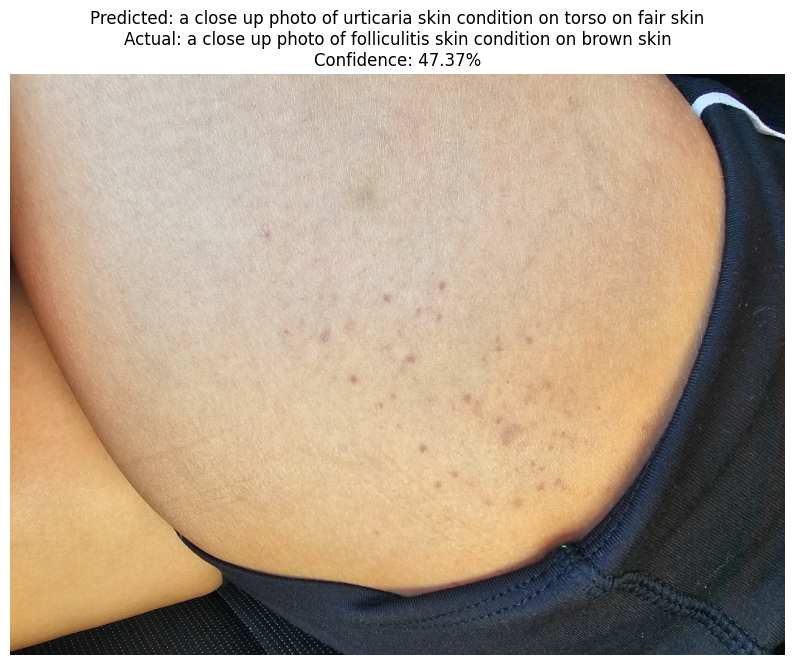

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/3590489756829695100.png
Actual Prompt: a at an angle photo of eczema skin condition on arms on white skin
Predicted Label: a at distance photo of eczema skin condition on arms on white skin
Prediction Confidence: 44.30%
True Label Confidence: 28.72%
--------------------------------------------------


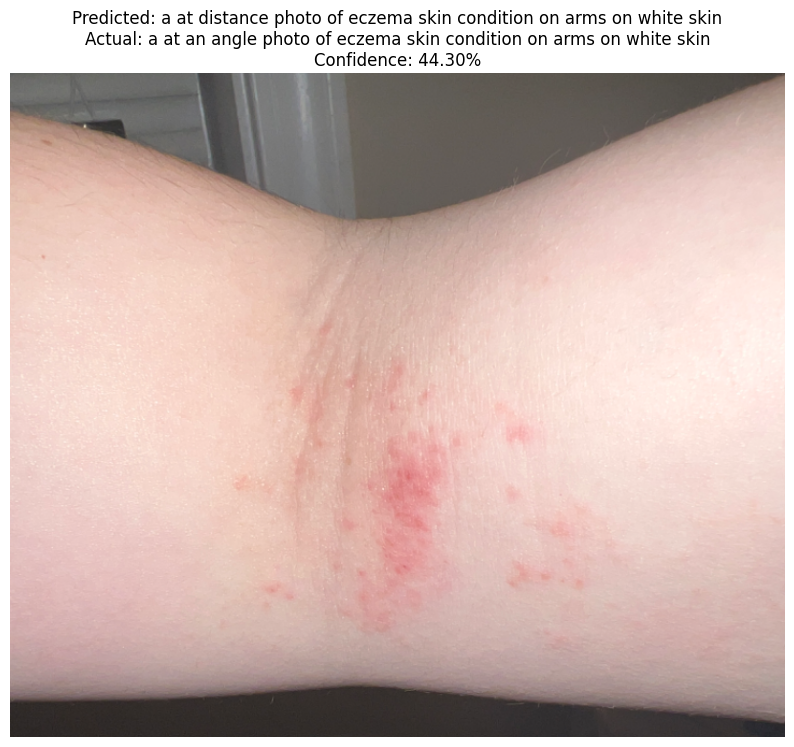

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/-9170015725324326381.png
Actual Prompt: a at an angle photo of eczema skin condition on arms on white skin
Predicted Label: a at an angle photo of eczema skin condition on arms on white skin
Prediction Confidence: 35.33%
True Label Confidence: 35.33%
--------------------------------------------------


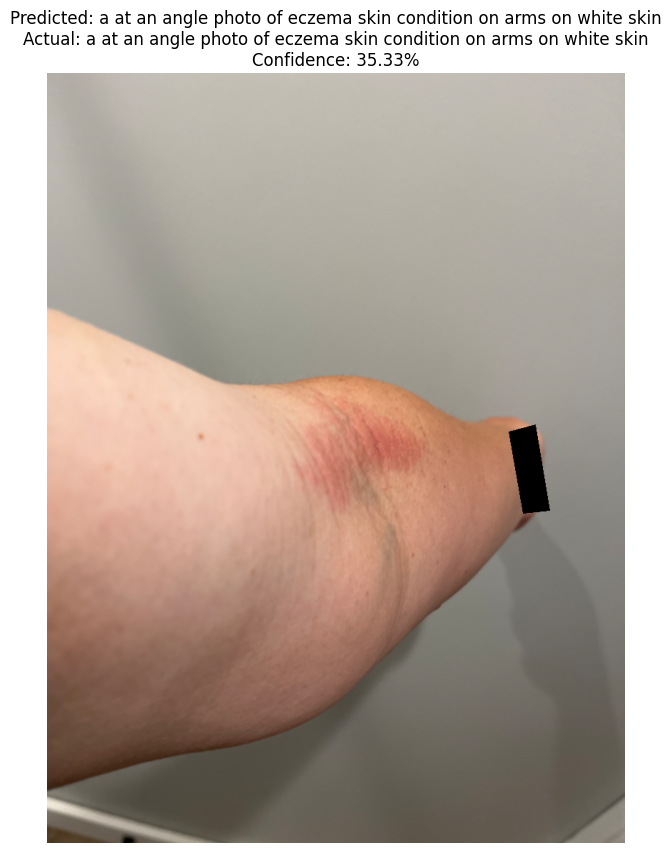

In [ ]:
# Initialize the trainer
model_name = "openai/clip-vit-base-patch32"
trainer = CLIPTrainer(model_name, data_dir, metadata_path,
                      batch_size=32, learning_rate=5e-5, num_epochs=3,
                      use_scheduler=True, save_interval=1)

# Train the model
trainer.train()

# Run inference on the test set
trainer.run_inference_on_test_set('final_model', num_samples=5)

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/8943452377015009675.png
Actual Prompt: a close up photo of urticaria skin condition on arms on brown skin
Predicted Label: a close up photo of urticaria skin condition on arms on brown skin
Prediction Confidence: 22.03%
True Label Confidence: 22.03%
--------------------------------------------------


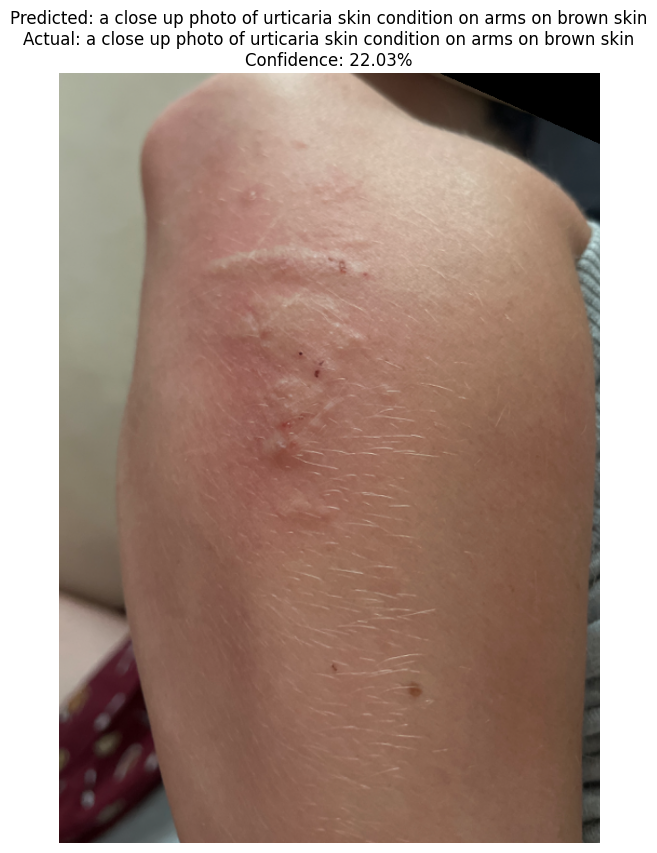

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/-9071217807268156605.png
Actual Prompt: a close up photo of eczema skin condition on arms on fair skin
Predicted Label: a close up photo of urticaria skin condition on arms on brown skin
Prediction Confidence: 29.53%
True Label Confidence: 13.43%
--------------------------------------------------


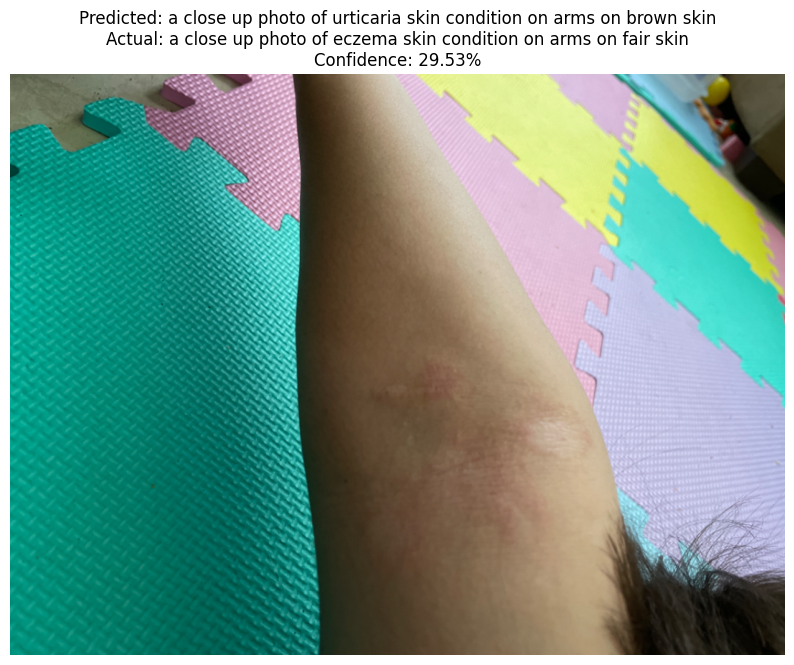

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/3358565101040151385.png
Actual Prompt: a close up photo of allergic contact dermatitis skin condition on arms on fair skin
Predicted Label: a at an angle photo of eczema skin condition on arms on white skin
Prediction Confidence: 31.11%
True Label Confidence: 14.40%
--------------------------------------------------


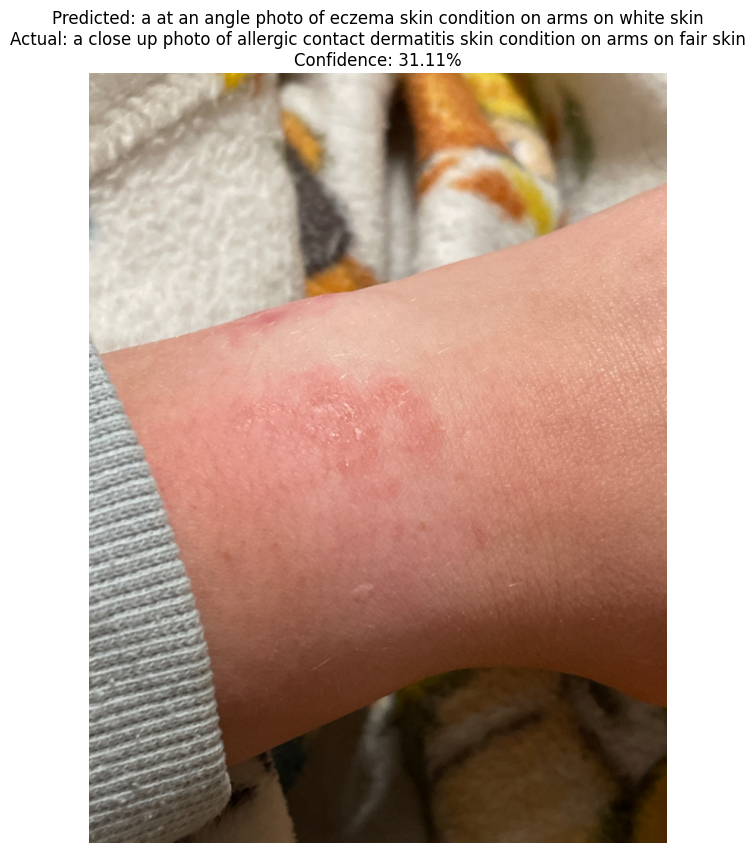

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/8187403870754700072.png
Actual Prompt: a at an angle photo of urticaria skin condition on back on white skin
Predicted Label: a at an angle photo of urticaria skin condition on back on white skin
Prediction Confidence: 90.83%
True Label Confidence: 90.83%
--------------------------------------------------


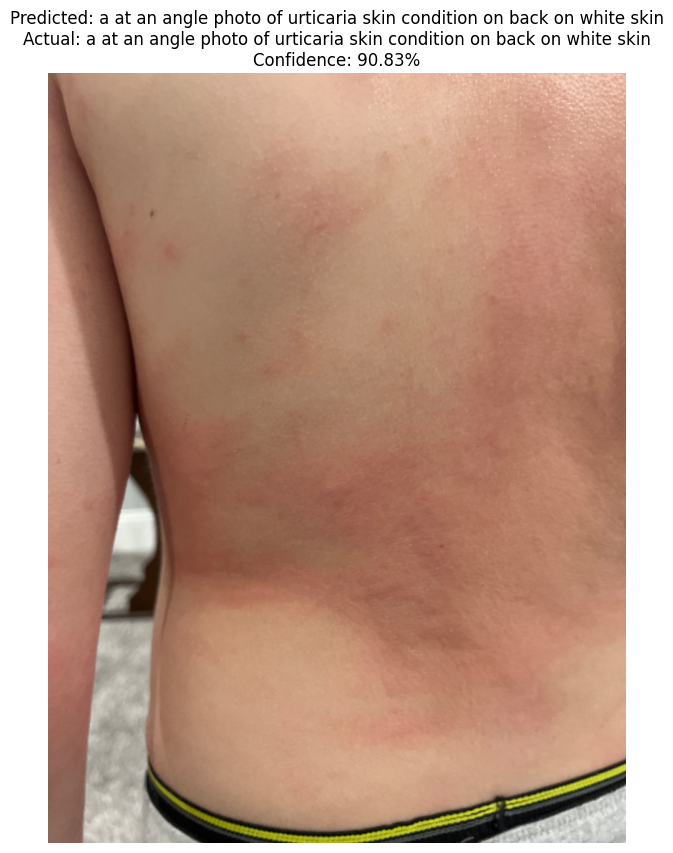

Image: /content/drive/MyDrive/CLIP_training_data/training_imgs/2432074176479085493.png
Actual Prompt: a close up photo of folliculitis skin condition on white skin
Predicted Label: a close up photo of allergic contact dermatitis skin condition on arms on white skin
Prediction Confidence: 25.54%
True Label Confidence: 0.10%
--------------------------------------------------


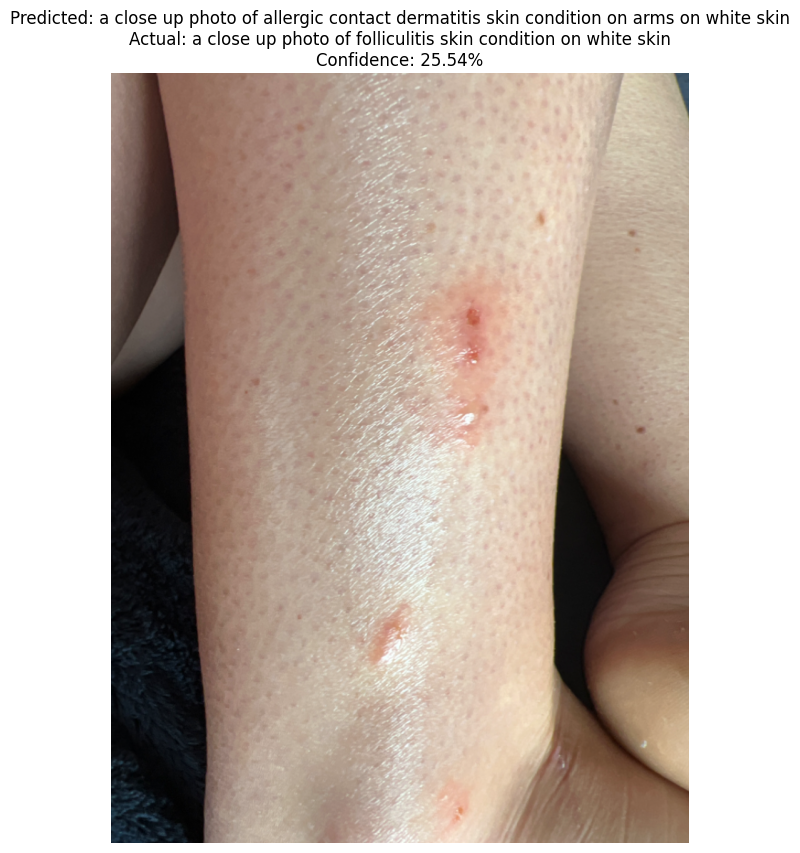

In [ ]:
import shutil
from google.colab import files

# Define the directory to zip
checkpoint_dir = '/content/model_checkpoints'

# Create a zip file of the directory
shutil.make_archive('model_checkpoints', 'zip', checkpoint_dir)

# Download the zip file
files.download('model_checkpoints.zip')

# Integrating the trained clip model into Diffusion model

In [ ]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, UniPCMultistepScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from PIL import Image
import numpy as np

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# Path to your fine-tuned CLIP model
clip_model_path = "sayeedahmed/clip-finetune-derma-test"

text_encoder = CLIPTextModel.from_pretrained(clip_model_path)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Move the models to the GPU
text_encoder = text_encoder.to("cuda")
# tokenizer = tokenizer.to("cuda")
unet = unet.to("cuda")
vae = vae.to("cuda")

# Freeze the models
text_encoder.eval()
# tokenizer.eval()
unet.eval()
vae.eval()



# Inspect the text encoder's hidden size
hidden_size = text_encoder.config.hidden_size
print("Hidden size of the text encoder:", hidden_size)

# Modify UNet to accept the correct hidden size
unet.config.cross_attention_dim = hidden_size  # Set to match your text encoder's hidden size

# Iterate over attention blocks and adjust linear layers
for name, module in unet.named_modules():
    if isinstance(module, torch.nn.Linear):
        if module.in_features != hidden_size:
            module.in_features = hidden_size  # Adjust input features to match new hidden size

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# Create a custom pipeline
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
    requires_safety_checker=False
)

# Move pipeline to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = pipeline.to(device)

# Set inference parameters
num_images_per_prompt = 4
num_inference_steps = 50
guidance_scale = 7.5
height = 512
width = 512

# Generate images
prompts = [
    "a close up photo of urticaria skin condition on arms on brown skin",
    "generate an image of an acne type of rash on the cheek area on a fair skin"
]

all_images = []

for prompt in prompts:
    images = pipeline(
        prompt,
        num_images_per_prompt=num_images_per_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width
    ).images
    all_images.extend(images)

    # Create and save a grid for this prompt
    grid = image_grid(images, rows=1, cols=num_images_per_prompt)
    grid.save(f"grid_{prompt[:20]}.png")

# Create and save a grid of all images
final_grid = image_grid(all_images, rows=len(prompts), cols=num_images_per_prompt)
final_grid.save("final_grid.png")

print("Image generation complete. Grids saved.")

Hidden size of the text encoder: 512


scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (616x512 and 768x320)